### Ground-truth based evaluation on information retrieval componenet 
When developing a RAG application, the retrieval component plays a critical role in the entire system. Thus, we need to be able to quickly measure the search quality, where directly affects an end-to-end LLM powered application's ability to accurately answer queries based on contextualized knowledge. In this notebook, we walkthrough how you can leverage your curated ground truth datasets containing golden contexts that are relevant to a query to perform evalaution using well established information retrieval (IR) metrics of your app. The key different from this ground-truth-based workflow than RAG triad is that RAG triad is reference free, and is mostly suitable for cases when ground truth data are not available.     

In [ ]:
# !pip install trulens trulens-provider-openai openai

In [ ]:
import os

os.environ["OPENAI_API_KEY"] = "sk-..."

In [ ]:
from trulens.core import TruSession

session = TruSession()
session.reset_database()

### Add and create your custom ground-truth dataset to TruLens


Here we create a dummy custom dataset for illustration purposes, and at the end of this notebook we will showcase a faster way to get started with a dozens of well-established IR benchmarks in BEIR (https://github.com/beir-cellar/beir)

In [ ]:
import pandas as pd

data = {
    "query": ["what is AI?"],
    "query_id": ["1"],
    "expected_response": ["Artificial Intelligence"],
    "expected_chunks": [
        [
            {
                "text": "AI is the simulation of human intelligence processes by machines, especially computer systems.",
                "title": "AI is not a bubble :(",
                "expected_score": 0.9,
            },
            {
                "text": "AI is the evil overlod that's going to rule over all human beings.",
                "title": "AI should be feared",
                "expected_score": 0.4,
            },
            {
                "text": "AI is the future of humanity.",
                "title": "AI is the future",
                "expected_score": 0.5,
            },
        ],
    ],
}

df = pd.DataFrame(data)

In [ ]:
session.add_ground_truth_to_dataset(
    dataset_name="test_dataset_ir",
    ground_truth_df=df,
    dataset_metadata={"domain": "Random IR dataset"},
)

In [ ]:
ground_truth_df = session.get_ground_truth("test_dataset_ir")

### The schema for ground truth datasets in TruLens contains the following columns:

```
query: str
expected_response: optionl[str]
expected_chunks: optional[List[Dict]]
```

In expected chunks, each dictionary (json) takes keys including a mandatory "text" field, and optionally "expected_score" field. `expected_score` is typically returned or generated by some retrievers or retrieval models. 



### Inspecting the below dataframe to see the columns and their value

In [ ]:
ground_truth_df

In [ ]:
from trulens.core import Feedback
from trulens.core.schema.select import Select
from trulens.feedback import GroundTruthAgreement
from trulens.providers.openai import OpenAI as fOpenAI

# define argument selectors (Lens) based on the setup of the application so that the feedback can be applied to the correct function calls
arg_query_selector = (
    Select.RecordCalls.retrieve_and_generate.args.query
)  # 1st argument of retrieve_and_generate function
arg_retrieval_k_selector = (
    Select.RecordCalls.retrieve_and_generate.args.k
)  # 2nd argument of retrieve_and_generate function

arg_completion_str_selector = Select.RecordCalls.retrieve_and_generate.rets[
    0
]  # 1st returned value from retrieve_and_generate function
arg_retrieved_context_selector = Select.RecordCalls.retrieve_and_generate.rets[
    1
]  # 2nd returned value from retrieve_and_generate function
arg_relevance_scores_selector = Select.RecordCalls.retrieve_and_generate.rets[
    2
]  # last returned value from retrieve_and_generate function

f_ir_hit_rate = (
    Feedback(
        GroundTruthAgreement(ground_truth_df, provider=fOpenAI()).ir_hit_rate,
        name="IR hit rate",
    )
    .on(arg_query_selector)
    .on(arg_retrieved_context_selector)
    .on(arg_retrieval_k_selector)
)

f_ndcg_at_k = (
    Feedback(
        GroundTruthAgreement(ground_truth_df, provider=fOpenAI()).ndcg_at_k,
        name="NDCG@k",
    )
    .on(arg_query_selector)
    .on(arg_retrieved_context_selector)
    .on(arg_relevance_scores_selector)
    .on(arg_retrieval_k_selector)
)


f_recall_at_k = (
    Feedback(
        GroundTruthAgreement(ground_truth_df, provider=fOpenAI()).recall_at_k,
        name="Recall@k",
    )
    .on(arg_query_selector)
    .on(arg_retrieved_context_selector)
    .on(arg_relevance_scores_selector)
    .on(arg_retrieval_k_selector)
)
f_groundtruth_answer = (
    Feedback(
        GroundTruthAgreement(ground_truth_df).agreement_measure,
        name="Ground Truth answer (semantic similarity)",
    )
    .on(arg_query_selector)
    .on(arg_completion_str_selector)
)

In [ ]:
from typing import List, Tuple

from openai import OpenAI
from trulens.apps.custom import TruCustomApp
from trulens.apps.custom import instrument

oai_client = OpenAI()


class APP:
    @instrument
    def retrieve_and_generate(
        self, query: str, k: int
    ) -> Tuple[str | None, List[str], List[float]]:
        # k is needed for specific metrics computation like NDCG@k
        completion_str = (
            oai_client.chat.completions.create(
                model="gpt-3.5-turbo",
                temperature=0,
                messages=[
                    {
                        "role": "user",
                        "content": f"Please answer the question: {query}",
                    }
                ],
            )
            .choices[0]
            .message.content
        )
        retrieved_chunks = [
            "AI is the future of humanity.",
            "AI is going to replace all human labor.",
        ]
        retrieval_scores = [
            1.0,
            0.85,
        ]  # optional scores typically come from a retrieval model
        return completion_str, retrieved_chunks, retrieval_scores


retrieval_app = APP()
# add trulens as a context manager for llm_app


tru_app = TruCustomApp(
    retrieval_app,
    app_name="Retrieval App v1",
    feedbacks=[f_ir_hit_rate, f_ndcg_at_k, f_recall_at_k, f_groundtruth_answer],
)

In [ ]:
with tru_app as recording:
    resp = retrieval_app.retrieve_and_generate("what is AI?", 2)

In [ ]:
session.get_leaderboard(app_ids=[tru_app.app_id])

#### Below is an example of computing 3 IR metrics: IR hit rate, NDCG at 2, and recall at 2, as well as a LLM-judged semantic similarity between generated answers (completion_str) and the ground truth `expected_response` 

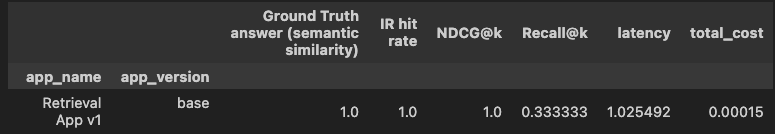

#### Using BEIR (Benchmarking IR) data loader to use a wide range of preprocessed public benchmark datasets, such as Hotpot QA, MS MARCO, Scifact, etc. 

At times, it can feel cumbersone to write and transform custom datasets when one just wants to get started quickly with some performance testing on the information retrieval component in their applications. TruLens provides `beir_loader` and all datasets are pre-processed and can be persisted to any SQL-compatible DB in few lines of code. 

### Simply specify the name of dataset and you are good to go 
the name of supported BEIR datasets can be found: https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/ 

In [ ]:
from trulens.benchmark.benchmark_frameworks.dataset.beir_loader import (
    TruBEIRDataLoader,
)

beir_data_loader = TruBEIRDataLoader(data_folder="./", dataset_name="scifact")
scifact_gt_df = beir_data_loader.load_dataset_to_df(download=True)

In [ ]:
scifact_gt_df

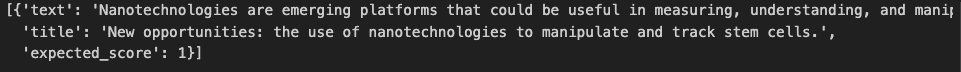

### And now the dataframe can be used to benchmark your retrieval component as shown above! 


```
# define NDCG at K metric on Scifact dataset
f_ndcg_at_k = (
    Feedback(
        GroundTruthAgreement(scifact_gt_df, provider=fOpenAI()).ndcg_at_k,
        name="NDCG@k",
    )
    .on(arg_query_selector)
    .on(arg_retrieved_context_selector)
    .on(arg_relevance_scores_selector)
    .on(arg_retrieval_k_selector)
)
```